In [1]:
import geopandas as gpd
from osgeo import gdal
from os import path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import date
from PIL import Image
import json

def convert_coords_to_pixels(points_list: list[tuple[int, int]], img_path):
    dataset = gdal.Open(img_path)
    transform = dataset.GetGeoTransform()

    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = -transform[5]

    pixels_bbox = []
    for point in points_list:
        col = int((point[0] - xOrigin) / pixelWidth)
        row = int((yOrigin - point[1] ) / pixelHeight)
        pixels_bbox.append([col,row])

    return pixels_bbox

def convert_bounds_to_pixel_bbs(bounds: tuple[int, int, int, int,], img_path: str):
    x_min, y_min, x_max, y_max = bounds
    [x_min, y_min], [x_max, y_max] = convert_coords_to_pixels([(x_min, y_min), (x_max, y_max)], img_path)
    return (x_min, y_min, x_max, y_max)

def draw_img(ax, img_path, bbox_list, color: str='r'):
    im = Image.open(img_path)
    ax.imshow(im)
    ax.set_axis_off()

    for bbox in bbox_list:
        x_min, y_min, x_max, y_max = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=color, facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

def write_json_file(json_path, data):
    with open(json_path, 'w') as f:
        json.dump(data, f)

In [2]:
# COCO dataset classes and converter functions

class CocoAnnotation:
    def __init__(self, category_id: int, bbox: tuple[int, int, int, int], image_id: int):
        self.category_id = category_id
        self.bbox = bbox
        self.image_id = image_id
    def __dict__(self):
        return {
            "category_id": self.category_id,
            "bbox": self.bbox,
            "image_id": self.image_id
        }

class CocoImage:
    def __init__(self, id: int, file_name: str, width: int, height: int):
        self.id = id
        self.file_name = file_name
        self.height = height
        self.width = width

    def __dict__(self):
        return {
            "id": self.id,
            "file_name": self.file_name,
            "height": self.height,
            "width": self.width
        }

class CocoCategory:
    def __init__(self, id: int, name: str):
        self.id = id
        self.name = name

    def __dict__(self):
        return {
            "id": self.id,
            "name": self.name
        }

class CocoDataset:
    def __init__(self, annotations: list[CocoAnnotation], categories: list[CocoCategory], images: list[CocoImage]):
        self.images = images
        self.annotations = annotations
        self.categories = categories
        self.info = {
            "description": "Riki's dataset",
            "date_created": date.today().strftime('%Y/%m/%d'),
            "version": "1.0",
        }
        self.licenses = []

    def __dict__(self):
        return {
            "info": self.info,
            "licenses": self.licenses,
            "categories": [category.__dict__() for category in self.categories],
            "images": [image.__dict__() for image in self.images],
            "annotations": [annotation.__dict__() for annotation in self.annotations]
        }

def convert_gdf_to_coco_annotations(gdf: gpd.GeoDataFrame, img_path: str, image_id: int):
    annotations = []
    for _, row in gdf.iterrows():
        bbox = convert_bounds_to_pixel_bbs(row.geometry.bounds, img_path)
        category_id = category_name_to_id(row.type)
        annotations.append(CocoAnnotation(category_id, bbox, image_id))

    return annotations

def convert_image_to_coco_image(img_path: str, image_id: int):
    img = Image.open(img_path)
    width, height = img.size
    return CocoImage(image_id, path.basename(img_path), width, height)

def category_name_to_id(name: str):
    if name == "snag":
        return 1
    elif name == "fallen":
        return 2
    else:
        raise ValueError(f"Invalid category name '${name}'")

def create_coco_dataset(file_start_n: int, nof_files: int, category_names: list[str], rgb_dir: str, snags_dir: str, fallen_dir: str):
    annotations: list[CocoAnnotation] = []
    images: list[CocoImage] = []
    for i in range(file_start_n, nof_files + file_start_n):
        img_path = path.join(rgb_dir, f'{i}.tif')
        images.append(convert_image_to_coco_image(img_path, i))
        for geojson_dir in [snags_dir, fallen_dir]:
            gdf = gpd.read_file(path.join(geojson_dir, f'{i}.geojson'))
            for annotation in convert_gdf_to_coco_annotations(gdf, img_path, i):
                annotations.append(annotation)

    categories: list[CocoCategory] = [CocoCategory(category_name_to_id(name), name) for name in category_names]
    return CocoDataset(annotations, categories, images)

/Users/rosasam/code/geojson2coco/venv/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


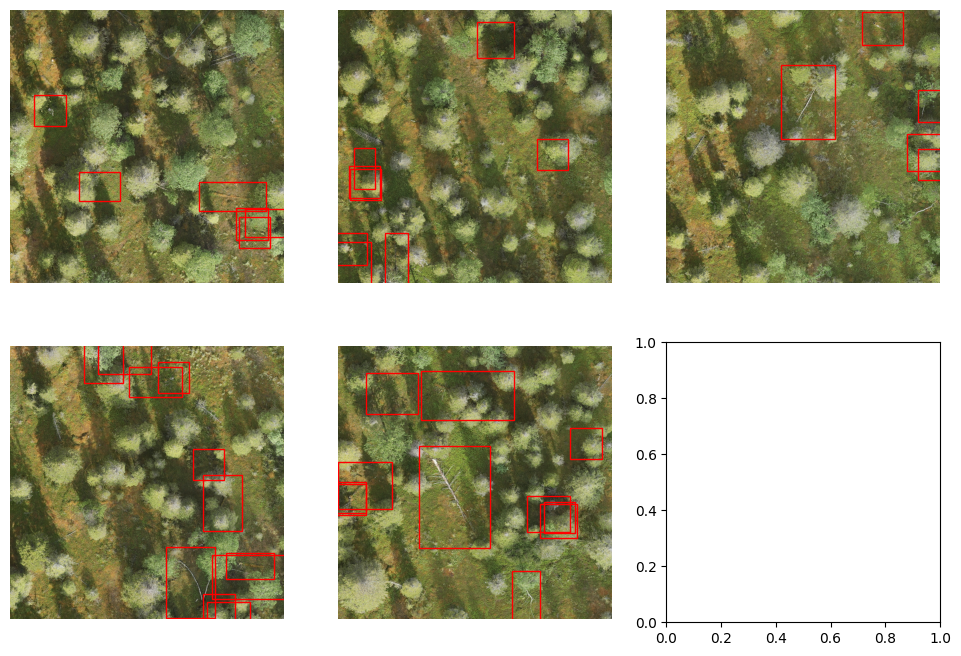

In [3]:
file_start_n = 99
nof_files = 5

categories = ['snag', 'fallen']

data_dir = 'dataset_trees'
snags_dir = path.join(data_dir, 'labels_snags')
fallen_dir = path.join(data_dir, 'labels_fallen')
rgb_dir = path.join(data_dir, 'rasterchips_rgb')

bboxes_by_image = []
# Iterate over each image
for i in range(file_start_n, nof_files + file_start_n):
    bboxes_by_category = []

    # Collect geojson data from both categories to one list
    for geojson_dir in [snags_dir, fallen_dir]:
        img_path = path.join(rgb_dir, f'{i}.tif')
        labels_json = gpd.read_file(path.join(geojson_dir, f'{i}.geojson'))

        bbox_list = []
        for row in labels_json.itertuples():
            bbox_list.append(convert_bounds_to_pixel_bbs(row.geometry.bounds, img_path))

        bboxes_by_category.append(bbox_list)

    # Flatten the list of lists before appending
    bboxes_by_image.append([bbox for bbox_list in bboxes_by_category for bbox in bbox_list])

# Create figure and axes
fig, axes = plt.subplots(2, 3, figsize=(6*2, 4*2))

for (i, bboxes) in enumerate(bboxes_by_image):
    draw_img(axes[i % 2, i // 2], path.join(rgb_dir, f'{i + file_start_n}.tif'), bboxes)

plt.show()

data = create_coco_dataset(file_start_n, nof_files, categories, rgb_dir, snags_dir, fallen_dir)
write_json_file('coco.json', data.__dict__())